In [1]:
import sklearn 


In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

x, y = make_circles(
    n_samples=n_samples,
    noise=0.03,
    random_state=42
)

In [3]:
x.shape, y.shape

((1000, 2), (1000,))

In [4]:
import pandas as pd

circles = pd.DataFrame({"X1":x[:,0], "X2": x[:,1], "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


[toy_data](https://scikit-learn.org/stable/datasets/toy_dataset.html
)

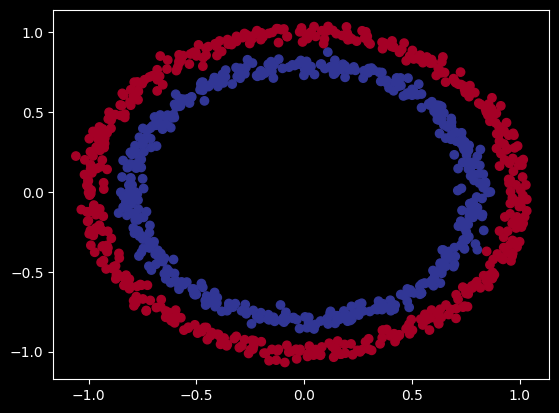

In [5]:
import matplotlib.pyplot as plt

plt.scatter(x =circles['X1'], y =circles['X2'], c= circles['label'], cmap = plt.cm.RdYlBu)

In [95]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.is_available()


True

In [96]:
features = circles[['X1', 'X2']]
features = torch.tensor(features.values, dtype=torch.float32)

target = circles['label']
target = torch.tensor(target.values, dtype= torch.float32)

xtrain = features[:800]
xtest = features[800:]
ytrain = target[:800]
ytest = target[800:]

In [97]:
type(xtrain)

torch.Tensor

In [98]:
from sklearn.model_selection import train_test_split

xtrain, xtest , ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 42)

xtrain = torch.tensor(xtrain, dtype=torch.float32).to(device)
xtest = torch.tensor(xtest, dtype=torch.float32).to(device)

ytrain = torch.tensor(ytrain, dtype= torch.float32).to(device)
ytest = torch.tensor(ytest, dtype= torch.float32).to(device)


In [11]:
type(xtrain)

torch.Tensor

# 1. Building Model 


- if Gpu is found then use it

In [18]:
class first_nn(nn.Module):
    def __init__(self):
        super().__init__()
        
        #* create input layer
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)
        
        #* you can use nn.sequential for sequnetial models
        # self.two_linear_layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1))

    def forward(self, x):
        #return two_linear_layers(x)
        inputs = x
        l1 = self.layer1(x)
        l2 = self.layer2(l1)
        return l2

In [20]:
model = first_nn()
model

first_nn(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [39]:
model = model.to(device)
print(next(model.parameters()).is_cuda)
model

True


first_nn(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [40]:
model.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.0538,  0.5106],
                      [ 0.5757,  0.5575],
                      [ 0.4326, -0.4838],
                      [ 0.7055,  0.0047],
                      [-0.2499,  0.3561]], device='cuda:0')),
             ('layer1.bias',
              tensor([-0.1732,  0.0952, -0.3620,  0.0487,  0.5536], device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.2262,  0.0923, -0.1874, -0.2872, -0.1906]], device='cuda:0')),
             ('layer2.bias', tensor([0.3898], device='cuda:0'))])

In [41]:
with torch.inference_mode():
    untrain_preds = model(xtest.to(device))
print(len(untrain_preds))
untrain_preds[:10], ytest[:10]

200


(tensor([[0.4302],
         [0.3422],
         [0.5366],
         [0.4006],
         [0.3392],
         [0.2870],
         [0.1957],
         [0.1822],
         [0.5447],
         [0.3341]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

# 2. Setting up Loss/Opt

In [43]:
#* setup loss function and opt

#loss_fn = nn.MSELoss()
loss_fn = nn.BCELoss() #* requires the inputs to go through a sigmoid actication func
#* check documentation
loss_fn = nn.BCEWithLogitsLoss() #* sigmoid activation function built in 


opt = torch.optim.SGD(params=model.parameters(),
                      lr = 0.03)

In [44]:
model.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.0538,  0.5106],
                      [ 0.5757,  0.5575],
                      [ 0.4326, -0.4838],
                      [ 0.7055,  0.0047],
                      [-0.2499,  0.3561]], device='cuda:0')),
             ('layer1.bias',
              tensor([-0.1732,  0.0952, -0.3620,  0.0487,  0.5536], device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.2262,  0.0923, -0.1874, -0.2872, -0.1906]], device='cuda:0')),
             ('layer2.bias', tensor([0.3898], device='cuda:0'))])

In [70]:
values = torch.eq(torch.tensor([[1, 2], [3, 4]]), torch.tensor([[1, 1], [4, 4]]))
print(values.sum())
print(values.sum().item())
print(values)

tensor(2)
2
tensor([[ True, False],
        [False,  True]])


In [140]:
## accuracy function

def accuracy_fn(y_true, y_pred):
    #* torch.eq => comparison between tensor, returns boolean
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = correct/(len(y_pred))*100
    return acc

## Sigmoid & prediction


In [141]:
model.eval()
with torch.inference_mode():
    y_logits =  model(xtest.to(device))[:5]
    
y_logits, ytest[:5]

(tensor([[-0.1269],
         [-0.0967],
         [-0.1908],
         [-0.1089],
         [-0.1667]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.], device='cuda:0'))

In [142]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs 

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], device='cuda:0')

In [143]:
torch.round(y_pred_probs).squeeze()

tensor([0., 0., 0., 0., 0.], device='cuda:0')

sigmoids -> set threshold to 0.5 or any wanted number 

if `ypred_probs` > 0.5: -> set to 1 else 0 , ie class 1 or class 0

In [144]:
predicted_labels = torch.round(torch.sigmoid(y_logits)).squeeze()
predicted_labels, ytest[:5]

(tensor([0., 0., 0., 0., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.], device='cuda:0'))

In [145]:
#* check for quality

print(torch.eq(predicted_labels, ytest[:5].to(device)))

tensor([False,  True, False,  True, False], device='cuda:0')


# 3. Training

In [146]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
nn.BCEWithLogitsLoss() #* expects logits as raw input
nn.BCELoss()#* expects predictions probabilities


In [157]:
model = first_nn()
model.to(device)

first_nn(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [158]:
epochs = 100
train_acc_hist = []
test_acc_hist = []
train_loss_hist = []
test_lost_hist = []
epoch_hist = []

for epoch in range(epochs):
    ##training
    model.train()
    
    #*1. forward pass
    #* predict -> squeeze -> sigmoid -> round
    y_logits = model(xtrain).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) 
    
    #*2 calculate loss / acc 
    loss = loss_fn(y_logits, ytrain) 
    acc = accuracy_fn(y_true= ytrain, y_pred=y_pred)
    
    #*3 optimizer 0 grad
    opt.zero_grad()
    
    #*4 backword porp
    loss.backward()
    
    #* optimer step
    opt.step()
    
    ## testing
    model.eval()
    with torch.inference_mode():
        y_logits = model(xtest).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
        
        test_loss = loss_fn(y_logits, ytest)
        test_acc = accuracy_fn(y_true=ytest, y_pred=y_pred)
        
        if epoch % 100 ==0 :
            print(f"Epoch {epoch} \ntrain =>  | Accuracy : {acc:.2f}% | loss : {loss:.5f}")
            print(f"test =>  | Accuracy : {test_acc:.2f}% | loss : {test_loss:.5f} \n")
            train_acc_hist.append(acc)
            train_loss_hist.append(loss)
            test_acc_hist.append(test_acc)
            test_lost_hist.append(test_loss)
            epoch_hist.append(epoch)


Epoch 0 
train =>  | Accuracy : 47.88% | loss : 0.70277
test =>  | Accuracy : 46.00% | loss : 0.71279 



In [163]:
from functions import *
#plt.style.available
plt.style.use('seaborn-v0_8-dark',)

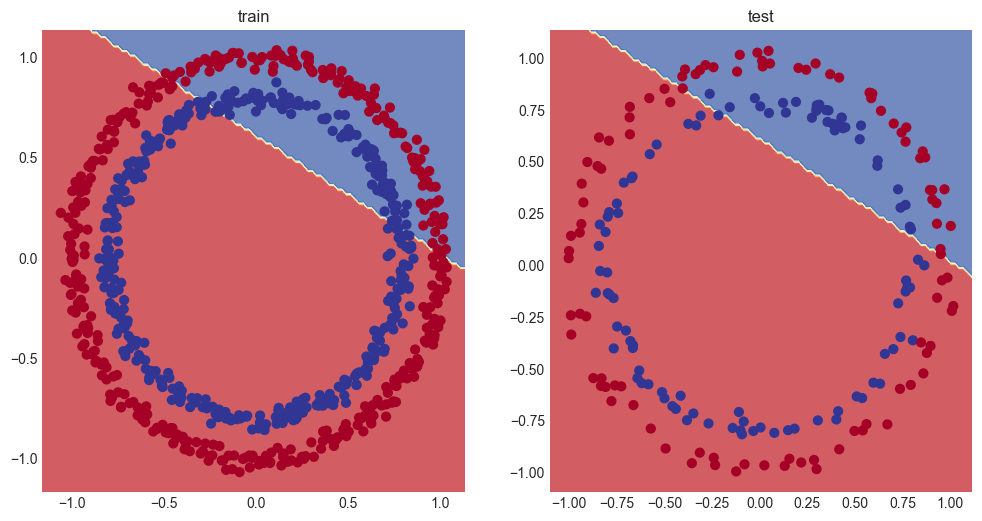

In [164]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model, xtrain, ytrain)

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model, xtest, ytest)